In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize
import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import re

# --- Function to extract numeric part from filenames ---
def numeric_sort_key(filename):
    # Use regular expression to extract numeric part from filename (this assumes filenames contain numbers)
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else 0  # Default to 0 if no number is found

# --- Load the data ---

# Paths to the dataset
train_data_path = '/kaggle/input/final-augmented-dataset/aug-and-images-20240918T063356Z-001/aug-and-images'
train_mask_data_path = '/kaggle/input/final-augmented-dataset/aug-and-masks-20240918T063354Z-001/aug-and-masks'

# Load images and masks (limit to 100 for demonstration)
training_images = sorted(os.listdir(train_data_path),key=numeric_sort_key )[0:1328]
training_masks = sorted(os.listdir(train_mask_data_path),key=numeric_sort_key )[0:1328]

# Image dimensions
row, columns = 512, 512

# Initialize arrays for images and masks
x_train = np.zeros((len(training_images), row, columns, 3), dtype=np.uint8)
y_train = np.zeros((len(training_masks), row, columns, 3), dtype=np.uint8)

# Load and resize images and masks
for index, name in enumerate(training_images):
    img_path = os.path.join(train_data_path, name)
    mask_path = os.path.join(train_mask_data_path, name)
    
    if os.path.exists(mask_path):
        image = imread(img_path)
        mask = imread(mask_path)
        
        x_train[index] = image
        y_train[index] = mask

In [2]:
x_train = x_train.astype('float32') / 255.0
y_train = y_train.astype('float32') / 255.0
y_train = (y_train > .5).astype(np.float32)

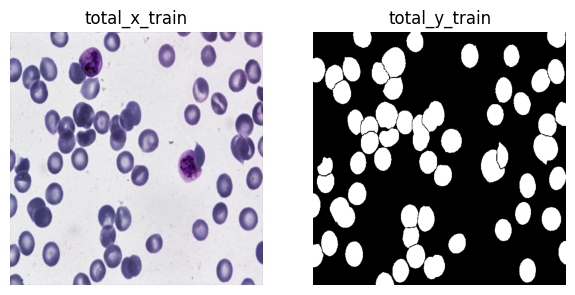

In [3]:
import matplotlib.pyplot as plt

# Plot the first image from x_train
plt.figure(figsize=(15, 5))  # Set figure size to display all images properly
index=12
plt.subplot(1, 4, 1)  # (1 row, 3 columns, first subplot)
plt.imshow(x_train[index])
plt.title('total_x_train')
plt.axis('off')  # Hide axes

# Plot the first image from augmented_masks
plt.subplot(1, 4, 2)  # (1 row, 3 columns, third subplot)
plt.imshow(y_train[index])
plt.title('total_y_train')
plt.axis('off')

# Display the images
plt.show()

In [4]:
from tensorflow.keras import  backend as K

def dice_coef(a, b):
          #  hi = K.hi
          #  hi = hi / 255
    
          #    hi = tf.convert_to_tensor(hi, dtype=None)
          #    pred = tf.convert_to_tensor(test_preds, dtype=None)
    hi = a
  #  hi = tf.dtypes.cast(hi, tf.float32)
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def dice_coef_loss(a, b):
    loss = 1 - dice_coef(a, b)
    return loss

def jaccard_index(a, b):
    hi = a 
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

In [5]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
import tensorflow as tf
def unet_model(input_size=(row, columns, 3)):
    inputs = Input(input_size)

    # Down-sampling path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Up-sampling path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [6]:
# --- Build and compile the model ---
model = unet_model()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# Compile with Dice loss and track Dice and Jaccard Index as metrics
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[dice_coef, jaccard_index])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 512,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,139 (7.40 MB)

 Trainable params: 1,941,139 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


earlystopper = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint('model.keras', save_best_only=True, verbose=1)

# --- Train the model ---
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=1, epochs=20, callbacks=[earlystopper, checkpoint])

Epoch 1/20


I0000 00:00:1727710972.482933      99 service.cc:145] XLA service 0x7f3f68002870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727710972.483034      99 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   6/1062 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - dice_coef: 0.3810 - jaccard_index: 0.2392 - loss: 0.6511  

I0000 00:00:1727710990.309914      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1061/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - dice_coef: 0.7221 - jaccard_index: 0.6301 - loss: 0.1986
Epoch 1: val_loss improved from inf to 0.06385, saving model to model.keras
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 54s 28ms/step - dice_coef: 0.7222 - jaccard_index: 0.6303 - loss: 0.1984 - val_dice_coef: 0.8511 - val_jaccard_index: 0.7960 - val_loss: 0.0639
Epoch 2/20
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - dice_coef: 0.8405 - jaccard_index: 0.7898 - loss: 0.0627
Epoch 2: val_loss improved from 0.06385 to 0.06267, saving model to model.keras
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - dice_coef: 0.8405 - jaccard_index: 0.7898 - loss: 0.0627 - val_dice_coef: 0.8618 - val_jaccard_index: 0.8141 - val_loss: 0.0627
Epoch 3/20
1060/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - dice_coef: 0.8593 - jaccard_index: 0.8101 - loss: 0.0607
Epoch 3: val_loss improved from 0.06267 to 0.05559, saving model to model.keras
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - dice_coef: 0.8593 - jaccard_index: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


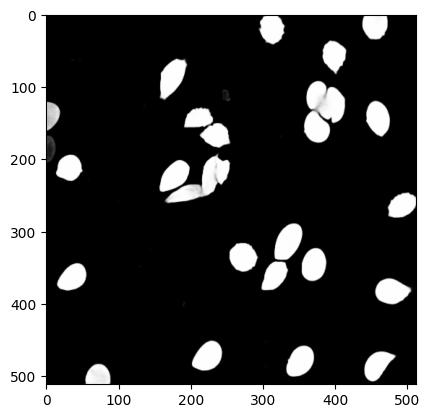

In [8]:
pred = model.predict(x_train[2:3])
pred = np.squeeze(pred)
plt.imshow(pred, cmap='gray')
plt.show()

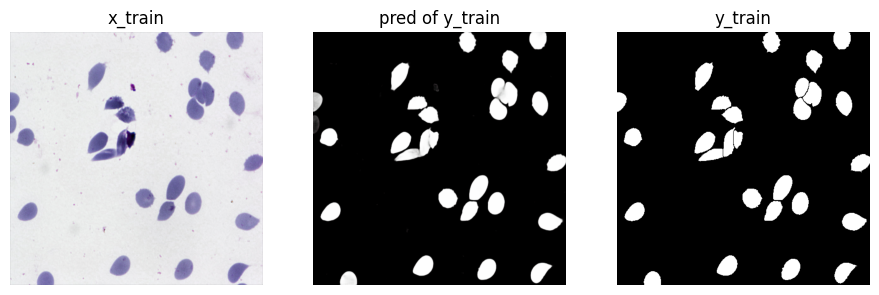

In [9]:
# Plot the first image from x_train
plt.figure(figsize=(15, 5))  # Set figure size to display all images properly
index=8
plt.subplot(1, 4, 1)  # (1 row, 3 columns, first subplot)
plt.imshow(np.squeeze(x_train[2:3]))
plt.title('x_train')
plt.axis('off')  # Hide axes

# Plot the first image from augmented_masks
plt.subplot(1, 4, 2)  # (1 row, 3 columns, third subplot)
plt.imshow(pred)
plt.title('pred of y_train')
plt.axis('off')

# Plot the first image from augmented_masks
plt.subplot(1, 4, 3)  # (1 row, 3 columns, third subplot)
plt.imshow(np.squeeze(y_train[2:3]))
plt.title('y_train')
plt.axis('off')

# Display the images
plt.show()

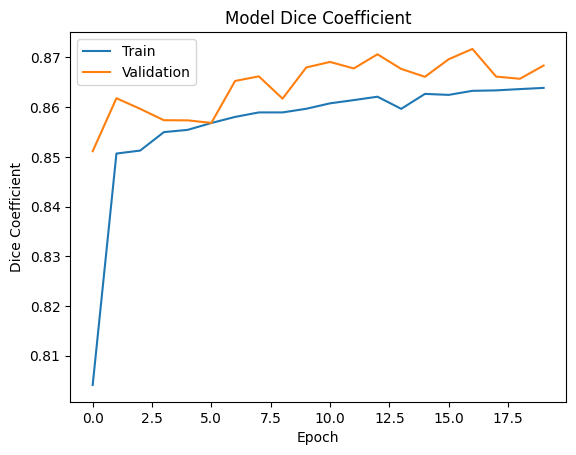

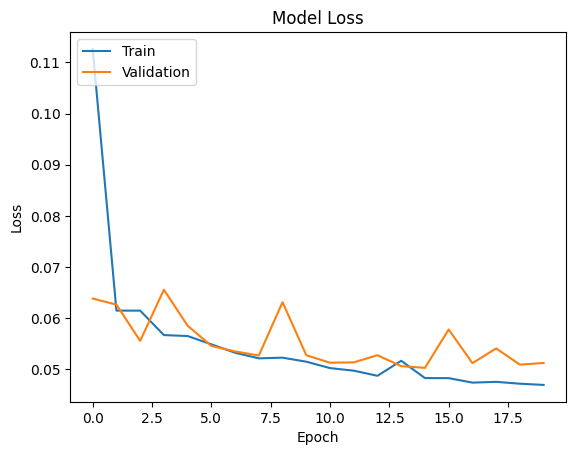

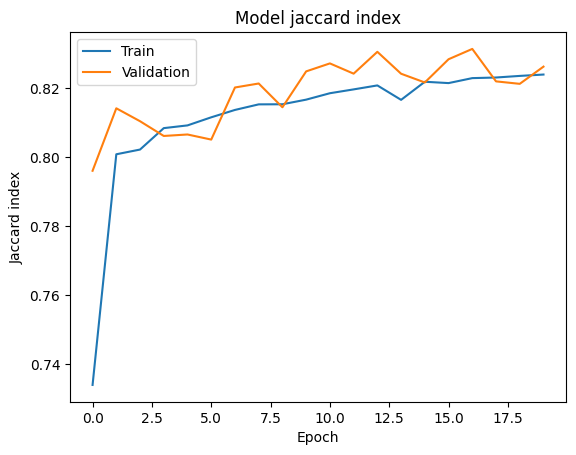

In [10]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()